パラメータ  
firstsize:初期個体数(population)  
life_length:寿命(year)  
cool_time:性成熟する年齢(year)  
x:初期集団のオスの性比(no unit)  
accident_rate:年間の事故での死亡割合(/year)  
born_rate:流産しない割合(?)  

その他  
iteration:世代数  
Nmax:個体数上限

死亡率と流産しない確率を連続で変化させて、最終個体数が増加しすぎないようなパラメータの範囲を探る

In [53]:
# ライブラリのインポート
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import statistics
import os
import itertools
import math

In [54]:
# 個体クラスの定義
class Agent():
    def __init__(self, life_length, accident_rate):
        self.sex = np.random.choice(['m', 'f'])
        self.life_length = life_length
        self.age = 0
        self.death_rate = (1/life_length) + accident_rate # 年間の死亡割合


    # 歳を取る
    def aging(self):
        self.age += 1

    # 死亡判定処理
    def judge_death(self):
        np.random.seed(self.random_seed)
        # 寿命で死亡
        if self.age >= self.life_length:
            return True
        else:
            return np.random.choice([True, False], p=[self.death_rate, (1-self.death_rate)])

In [55]:
# シミュレーションクラスの定義

# firstsize:初期個体数、Nmax:個体数上限、life_length:寿命、cool_time:性成熟する年齢
# x:初期集団のオスの比率、accident_rate:年間の事故での死亡割合、born_rate:流産しない割合

class Simulation():
    def __init__(self, firstsize, Nmax, life_length, cool_time, x=0.5, accident_rate=0, born_rate=1):
        self.population = self.__initialize(firstsize, life_length, accident_rate, x)
        self.Nmax = Nmax
        self.life_length = life_length
        self.cool_time = cool_time
        self.accident_rate = accident_rate
        self.born_rate = born_rate

        self.cwd = os.getcwd()
        self.population_size = [firstsize]
        self.sexratio = [x]


    # 初期集団をつくる
    def __initialize(self, firstsize, life_length, accident_rate, x):
        population = []

        # firstsizeとxに従って初期集団をつくる
        # 初期集団の個体の年齢はランダムに決定
        for i in range(int(firstsize * x)):
            focal = Agent(life_length, accident_rate)
            focal.sex = 'm'
            focal.age = np.random.randint(0, life_length)
            population.append(focal)

        for i in range(int(firstsize * (1-x))):
            focal = Agent(life_length, accident_rate)
            focal.sex = 'f'
            focal.age = np.random.randint(0, life_length)
            population.append(focal)

        np.random.shuffle(population)
        
        return population


    # 集団内の交尾
    def __copulation(self):

        if len([focal for focal in self.population if (focal.sex == 'm') and (focal.age > self.cool_time)]) >= 1:

            # 生殖可能なメス個体
            female_population = [focal for focal in self.population if (focal.sex == 'f') and (focal.age > self.cool_time)]

            # 流産しない個体を選ぶ
            chosen_female = [focal for focal in female_population if np.random.rand() <= self.born_rate]
        
            # メスが子供を産む
            for _ in chosen_female:
                self.population.append(Agent(self.life_length, self.accident_rate))

            np.random.shuffle(self.population)


    # 一定の死亡率で死亡
    # 寿命で死亡
    def __aging_and_death(self):
        for focal in self.population:
            focal.aging()
            if focal.judge_death():
                index = self.population.index(focal)
                del self.population[index]


    # 個体数抑制
    def __population_control(self):
        while len(self.population) > int(self.Nmax):
            index = np.random.randint(0, len(self.population))
            del self.population[index]


    # 個体数、性比を記録する
    def __calculation(self):
        p_size = len(self.population)
        m_size = len([focal for focal in self.population if focal.sex == 'm'])

        if p_size != 0:
            s_ratio = (m_size / p_size)
        else:
            s_ratio = 0

        self.population_size.append(p_size)
        self.sexratio.append(s_ratio)

    
    # 世代のシミュレーションを実行
    def run_one_episode(self, iteration, episode):
        for _ in range(iteration):
            self.__copulation()
            self.__aging_and_death()
            self.__population_control()
            self.__calculation()

        pd.DataFrame({
            'population size': self.population_size,
            'sex ratio': self.sexratio
        }).to_csv(os.path.join(self.cwd, 'result', f'episode_{episode}.csv'))

In [56]:
# main処理
# 死亡割合、流産しない割合を変化させて最終個体数の変化を観察
def main():
    cwd = os.getcwd()
    os.makedirs(os.path.join(cwd, 'result'), exist_ok=True)

    # パラメータの設定
    iteration = 50
    firstsize = 10
    Nmax = 10000
    life_length = 30
    cool_time = 5
    sex_ratio = 0.5
    accident_rate_array = np.linspace(0, 0.2, 11)
    born_rate_array = np.linspace(0, 1, 11)

    with open('result/parameters.csv', mode='a') as f:
        f.write('episode,accident rate,born rate\n')
        for i, (A, B) in enumerate(itertools.product(accident_rate_array, born_rate_array)):
            print(f'episode:{i}, A:{A}, B:{B}')
            simulation = Simulation(firstsize, Nmax, life_length, cool_time, sex_ratio, A, B)
            simulation.run_one_episode(iteration, episode=i)
            f.write(f'{i},{A},{B}\n')

if __name__ == '__main__':
    main()

episode:0, A:0.0, B:0.0
episode:1, A:0.0, B:0.1
episode:2, A:0.0, B:0.2
episode:3, A:0.0, B:0.30000000000000004
episode:4, A:0.0, B:0.4
episode:5, A:0.0, B:0.5
episode:6, A:0.0, B:0.6000000000000001
episode:7, A:0.0, B:0.7000000000000001
episode:8, A:0.0, B:0.8
episode:9, A:0.0, B:0.9
episode:10, A:0.0, B:1.0
episode:11, A:0.02, B:0.0
episode:12, A:0.02, B:0.1
episode:13, A:0.02, B:0.2
episode:14, A:0.02, B:0.30000000000000004
episode:15, A:0.02, B:0.4
episode:16, A:0.02, B:0.5
episode:17, A:0.02, B:0.6000000000000001
episode:18, A:0.02, B:0.7000000000000001
episode:19, A:0.02, B:0.8
episode:20, A:0.02, B:0.9
episode:21, A:0.02, B:1.0
episode:22, A:0.04, B:0.0
episode:23, A:0.04, B:0.1
episode:24, A:0.04, B:0.2
episode:25, A:0.04, B:0.30000000000000004
episode:26, A:0.04, B:0.4
episode:27, A:0.04, B:0.5
episode:28, A:0.04, B:0.6000000000000001
episode:29, A:0.04, B:0.7000000000000001
episode:30, A:0.04, B:0.8
episode:31, A:0.04, B:0.9
episode:32, A:0.04, B:1.0
episode:33, A:0.06, B:0.0

/var/folders/_w/f4z7dgpj7ds3kb9z3rbqw3lc0000gn/T/ipykernel_3592/3830062489.py:67: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  fig.colorbar(cont)
/var/folders/_w/f4z7dgpj7ds3kb9z3rbqw3lc0000gn/T/ipykernel_3592/3830062489.py:74: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


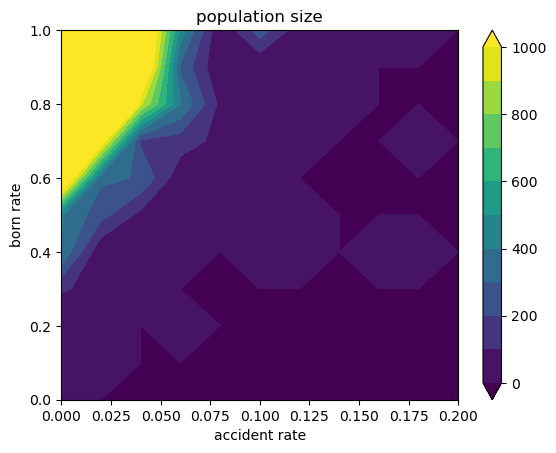

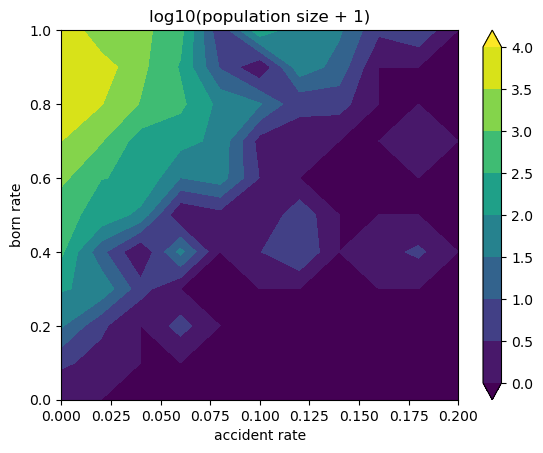

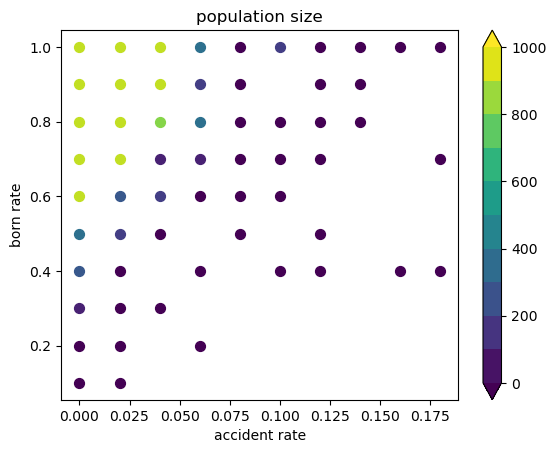

In [57]:
# 可視化
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata
import matplotlib.cm as cm # グラデーション用

def main():
    # データの読み込み
    params = pd.read_csv('result/parameters.csv', index_col=0)
    population_size = []
    population_size_log = []
    
    # 各シミュレーションの最終個体数を取ってくる
    for i in range(121):
        df = pd.read_csv(f'result/episode_{i}.csv')
        x = df['population size'][50] # 世代数手入力必要
        population_size.append(x)
        population_size_log.append(math.log10(x+1))

    # カラーバー用
    cb_list = np.linspace(0, 1000, 11)
    cb_list_log = np.linspace(0, 4, 9)


    # 図1
    fig = plt.figure()
    ax = fig.add_subplot(111)
    x, y = np.meshgrid(np.unique(params['accident rate']), np.unique(params['born rate']))
    z = griddata((params['accident rate'], params['born rate']), population_size, (x, y))
    cont = ax.contourf(x, y, z, cb_list, cmap='viridis', extend='both')
    fig.colorbar(cont)

    ax.set_title('population size')
    ax.set_xlabel('accident rate')
    ax.set_ylabel('born rate')
    # ax.set_zlabel('hawks_ratio')
    fig.savefig('tmp1.png', dpi=600)


    # 図2
    fig = plt.figure()
    ax = fig.add_subplot(111)
    x, y = np.meshgrid(np.unique(params['accident rate']), np.unique(params['born rate']))
    z = griddata((params['accident rate'], params['born rate']), population_size_log, (x, y))
    cont_log = ax.contourf(x, y, z, cb_list_log, cmap='viridis', extend='both')
    fig.colorbar(cont_log)

    ax.set_title('log10(population size + 1)')
    ax.set_xlabel('accident rate')
    ax.set_ylabel('born rate')
    # ax.set_zlabel('hawks_ratio')
    fig.savefig('tmp2.png', dpi=600)

    
    # 図3
    fig = plt.figure()
    ax = fig.add_subplot(111)
    p_size = pd.Series(population_size, name='p_size')
    df_2 = pd.concat([params, p_size], axis=1)
    value = [0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 10000] # 色分け用

    # p_sizeごとにdfをつくりそれぞれ違う色でプロット
    df_list =[]
    for i in range(11):
        data = df_2.query(f'{value[i]} < p_size <= {value[i+1]}')
        df_list.append(data)
    for i in range(11):
        df = df_list[i]
        ax.scatter(df['accident rate'], df['born rate'], s=50, c=[cm.viridis(i/11.0)])

    fig.colorbar(cont)
    ax.set_title('population size')
    ax.set_xlabel('accident rate')
    ax.set_ylabel('born rate')
    # ax.set_zlabel('population size')
    fig.savefig('tmp3.png', dpi=600)


    fig.show()

if __name__ == '__main__':
    main()